In [6]:
import numpy as np
import matplotlib.pyplot as plt
from JOPLEn.singletask import JOPLEn
from JOPLEn.st_penalty import NuclearNorm, SquaredFNorm, SquaredLaplacian
from JOPLEn.st_loss import SquaredError
from JOPLEn.partitioner import VPartition
from JOPLEn.enums import CellModel
from lightgbm import LGBMRegressor

n_points = 10000
n_train_points = 100
n_cells = 5
n_partitions = 20

In [7]:
np.random.seed(0)

x = np.random.uniform(-1, 1, (n_points, 2))
y = np.sin(np.pi * x[:, 0] + x[:, 1]) + np.random.normal(0, 0.2, n_points)

x_train = x[:n_train_points]
y_train = y[:n_train_points, None]

x_test = x[n_train_points:]
y_test = y[n_train_points:, None]

In [8]:
model = JOPLEn(
    partitioner=VPartition,
    n_cells=n_cells,
    n_partitions=n_partitions,
    loss_fn=SquaredError,
    cell_model=CellModel.linear,
    mu=1e-1,
    max_iters=1000,
    rescale=False,
    regularizers=[
        SquaredFNorm(1e-3),
    ],
)

history = model.fit(x_train, y_train, verbose=False)

y_pred_l2 = model.predict(x_test)

print("L2 error:", np.mean((y_pred_l2 - y_test) ** 2))

L2 error: 0.20289800026970853


In [9]:
model = JOPLEn(
    partitioner=VPartition,
    n_cells=n_cells,
    n_partitions=n_partitions,
    loss_fn=SquaredError,
    cell_model=CellModel.linear,
    mu=1e-1,
    max_iters=1000,
    early_stop=True,
    rescale=False,
    regularizers=[
        NuclearNorm(lam=1e-3),
    ],
)

history = model.fit(x_train, y_train)

y_pred_nn = model.predict(x_test)

print("NN error:", np.mean((y_pred_nn - y_test) ** 2))

NN error: 0.10739606888570075


In [10]:
model = LGBMRegressor(
    seed=0,
    verbose=-1,
    n_estimators=n_partitions,
    num_leaves=n_cells,
)

model.fit(x_train, y_train.flatten())

y_pred_lgbm = model.predict(x_test)[:, None]

print("LGBM error:", np.mean((y_pred_lgbm - y_test) ** 2))

LGBM error: 0.22781659829270903


/tmp/ipykernel_570986/3669349102.py:66: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


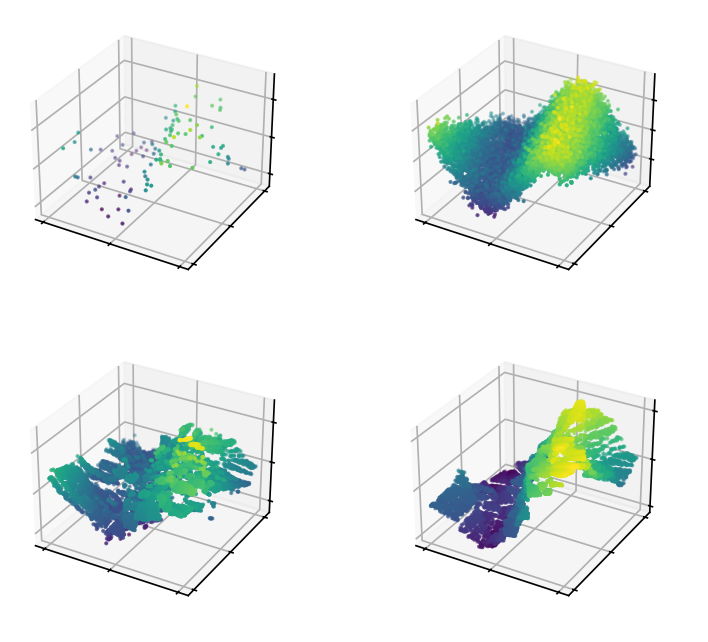

F-Norm Penalty Loss:       0.2029
Nuclear Norm Penalty Loss: 0.1074
LGBM Loss:                 0.2278


In [34]:
# Create a figure and a grid layout with 1 row and 2 columns
fig = plt.figure(dpi=150, figsize=(6, 8))

# Add the first subplot
axs = [fig.add_subplot(320 + i, projection="3d") for i in range(1, 5)]

shared_params = {
    "s": 1,
}

axs[0].scatter(
    x_train[:, 0],
    x_train[:, 1],
    y_train,
    c=y_train,
    **shared_params,
)
# axs[0].set_title("Training Data")

axs[1].scatter(
    x_test[:, 0],
    x_test[:, 1],
    y_test,
    c=y_test,
    **shared_params,
)
# axs[1].set_title("Testing Data")

axs[2].scatter(
    x_test[:, 0],
    x_test[:, 1],
    y_pred_l2,
    c=y_pred_l2,
    **shared_params,
)
# axs[2].set_title("F-Norm")

axs[3].scatter(
    x_test[:, 0],
    x_test[:, 1],
    y_pred_nn,
    c=y_pred_nn,
    **shared_params,
)
# axs[3].set_title("Nuclear Norm")

# axs[4].scatter(
#     x_test[:, 0],
#     x_test[:, 1],
#     y_pred_lgbm,
#     c=y_pred_lgbm,
#     **shared_params,
# )
# axs[4].set_title("Prediction with LGBM")

for ax in axs:
    # ax.set_xlabel("X1")
    # ax.set_ylabel("X2")
    # ax.set_zlabel("Y")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

# plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.tight_layout()

plt.show()

print(f"F-Norm Penalty Loss:       {np.mean((y_test - y_pred_l2) ** 2):.4f}")
print(f"Nuclear Norm Penalty Loss: {np.mean((y_test - y_pred_nn) ** 2):.4f}")
print(f"LGBM Loss:                 {np.mean((y_test - y_pred_lgbm) ** 2):.4f}")